# Ensemble Model Assignment---Firas Obeid 

For this assignment use data at: “https://www.kaggle.com/wendykan/lending-club-loan-data/download”

1.	Read the data and do the preprocessing similar to the GBM file submitted to eLearning. Try not to exclude any variable as much as possible.
2.	Split the sample to test and train.
3.	Use sklearn to build a GBM model to predict whether a customer has any delinquent account. Do Grid search on as many parameters as you find useful. Include “Number of Trees”, and “Learning Rate” for sure. Use the train sample.
4.	For each model, store the AUC on the test and train. At the end, choose the best model that gives you the best bias-variance.
5.	Draw a histogram for predicted probabilities in each class. Something like the following graph, where for example orange is class 0 and blue is class 1. How should the ideal graph look like?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\Firo Obeid\Anaconda3\envs\pyfinance\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data=pd.read_csv("loan.csv", low_memory= False)
data.shape

(2260668, 145)

In [3]:
raw_data = data.copy()
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Data Processing

In [4]:
# Choice Y variable: Loan Default or delinquent account 
# Choose acc_now_delinqfor  predicting if person has delinquent account for the purpose of the assignmnet
print("LOAN DEFAULT: ", data.loan_status.unique())
print("\nLOAN DEFAULTS VALUE COUNTS:\n", data.loan_status.value_counts())

LOAN DEFAULT:  ['Current' 'Fully Paid' 'Late (31-120 days)' 'In Grace Period'
 'Charged Off' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']

LOAN DEFAULTS VALUE COUNTS:
 Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [5]:
print("\nDELIQUMENT ACCOUNT: ", data.acc_now_delinq.unique())
print("\nDELIQUMENT ACCOUNT VALUE COUNTS: \n", data.acc_now_delinq.value_counts())
#drop all rows with missing values in target column acc_now_delinq
data.dropna(subset=['acc_now_delinq'], inplace=True)


DELIQUMENT ACCOUNT:  [ 0.  1.  2.  3.  4.  6.  5. 14.  7. nan]

DELIQUMENT ACCOUNT VALUE COUNTS: 
 0.0     2251857
1.0        8293
2.0         421
3.0          50
4.0          11
5.0           3
6.0           2
14.0          1
7.0           1
Name: acc_now_delinq, dtype: int64


In [6]:
# Specail Treatment for loan status variable 
loan_status = {'Current': 1, 'Fully Paid':1, 'Late (31-120 days)':0, 'In Grace Period': 1, 'Charged Off': 0, 'Late (16-30 days)': 1, 'Default':0,'Does not meet the credit policy. Status:Fully Paid': 1, 'Does not meet the credit policy. Status:Charged Off':0}

In [7]:
# Target variables: But we will choose to predict if a person has a delinquent account later in our model
data.loan_status = data.loan_status.map(loan_status)
data.acc_now_delinq = np.where(data['acc_now_delinq'] == 0, 0, 1)

In [10]:
# Which object dtype variables are useful and can be converted to categorical variables
for i in data.columns[data.dtypes == object].values:
    print(i, data[i].unique())

term [' 36 months' ' 60 months']
grade ['C' 'D' 'B' 'A' 'E' 'F' 'G']
sub_grade ['C1' 'D2' 'D1' 'C4' 'C3' 'C2' 'D5' 'B3' 'A4' 'B5' 'C5' 'D4' 'E1' 'E4'
 'B4' 'D3' 'A1' 'E5' 'B2' 'B1' 'A5' 'F5' 'A3' 'E3' 'A2' 'E2' 'F4' 'G1'
 'G2' 'F1' 'F2' 'F3' 'G4' 'G3' 'G5']
emp_title ['Chef' 'Postmaster ' 'Administrative' ... 'Sales, Estimating & Design'
 'Acft mechanic' 'BABYSITTER']
emp_length ['10+ years' '6 years' '4 years' '< 1 year' '2 years' '9 years' nan
 '5 years' '3 years' '7 years' '1 year' '8 years']
home_ownership ['RENT' 'MORTGAGE' 'OWN' 'ANY' 'NONE' 'OTHER']
verification_status ['Not Verified' 'Source Verified' 'Verified']
issue_d ['Dec-2018' 'Nov-2018' 'Oct-2018' 'Sep-2018' 'Aug-2018' 'Jul-2018'
 'Jun-2018' 'May-2018' 'Apr-2018' 'Mar-2018' 'Feb-2018' 'Jan-2018'
 'Sep-2016' 'Aug-2016' 'Jul-2016' 'Jun-2016' 'May-2016' 'Apr-2016'
 'Mar-2016' 'Feb-2016' 'Jan-2016' 'Dec-2016' 'Nov-2016' 'Oct-2016'
 'Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015'
 'Jun-2015' 'May-2015' 'Apr-

earliest_cr_line ['Apr-2001' 'Jun-1987' 'Apr-2011' 'Feb-2006' 'Dec-2000' 'Sep-2002'
 'Nov-2004' 'Nov-1997' 'Aug-1998' 'Apr-2002' 'May-2007' 'Dec-2003'
 'Jun-2003' 'Oct-2008' 'Jul-1990' 'Dec-1988' 'Dec-2002' 'Oct-2010'
 'Jul-2005' 'Feb-2001' 'Dec-2004' 'Oct-2001' 'Sep-2003' 'Oct-2004'
 'Sep-2010' 'Oct-1999' 'Feb-1997' 'Jan-1995' 'Aug-2005' 'Apr-2005'
 'Oct-2005' 'Nov-2006' 'Sep-1999' 'Sep-2006' 'Aug-1996' 'May-2015'
 'Nov-1999' 'Dec-1998' 'Aug-1989' 'Apr-2012' 'Sep-2012' 'Jan-2011'
 'Jul-2013' 'Sep-2011' 'Aug-1999' 'Dec-1991' 'Nov-2007' 'Oct-2007'
 'Jul-1986' 'Nov-2014' 'Apr-1995' 'Jul-1992' 'Aug-2006' 'Oct-1988'
 'Feb-2005' 'Aug-2002' 'Oct-2003' 'Apr-2004' 'Jun-2007' 'Aug-1990'
 'Dec-1990' 'Jul-1997' 'Sep-1988' 'Sep-2008' 'Feb-1999' 'Apr-2007'
 'Aug-2004' 'Dec-2006' 'Mar-2007' 'Oct-2006' 'Jul-2014' 'May-2005'
 'Jun-1995' 'Mar-2014' 'Feb-2003' 'Aug-2007' 'Jul-1996' 'Jan-1991'
 'Aug-2008' 'Dec-2007' 'Sep-1997' 'Jan-2000' 'Jan-2005' 'Feb-2007'
 'Dec-2005' 'Jan-2012' 'Dec-1997' 'Mar-2009' 

last_pymnt_d ['Feb-2019' 'Jan-2019' nan 'Dec-2018' 'Nov-2018' 'Oct-2018' 'Sep-2018'
 'Aug-2018' 'Jul-2018' 'Jun-2018' 'May-2018' 'Apr-2018' 'Mar-2018'
 'Feb-2018' 'Jan-2018' 'Oct-2017' 'Apr-2017' 'Jan-2017' 'Aug-2017'
 'Dec-2017' 'Nov-2017' 'Nov-2016' 'May-2017' 'Jul-2017' 'Mar-2017'
 'Jun-2017' 'Feb-2017' 'Oct-2016' 'Sep-2017' 'Dec-2016' 'Sep-2016'
 'Aug-2016' 'Jul-2016' 'Jun-2016' 'May-2016' 'Apr-2016' 'Mar-2016'
 'Feb-2016' 'Jan-2016' 'Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015'
 'Aug-2015' 'Jul-2015' 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015'
 'Feb-2015' 'Jan-2015' 'Aug-2014' 'Jul-2014' 'May-2014' 'Sep-2014'
 'Jun-2014' 'Nov-2014' 'Feb-2014' 'Jan-2014' 'Mar-2014' 'Dec-2014'
 'Oct-2014' 'Apr-2014' 'Dec-2013' 'Nov-2013' 'Oct-2013' 'Sep-2013'
 'Aug-2013' 'Jul-2013' 'Jun-2013' 'May-2013' 'Apr-2013' 'Mar-2013'
 'Feb-2013' 'Jan-2013' 'Dec-2012' 'Nov-2012' 'Oct-2012' 'Sep-2012'
 'Aug-2012' 'Jul-2012' 'Jun-2012' 'May-2012' 'Apr-2012' 'Mar-2012'
 'Feb-2012' 'Jan-2012' 'Dec-2011' 'Nov-2011' 

hardship_type [nan 'INTEREST ONLY-3 MONTHS DEFERRAL']
hardship_reason [nan 'UNEMPLOYMENT' 'NATURAL_DISASTER' 'EXCESSIVE_OBLIGATIONS' 'MEDICAL'
 'INCOME_CURTAILMENT' 'DISABILITY' 'REDUCED_HOURS' 'FAMILY_DEATH'
 'DIVORCE']
hardship_status [nan 'ACTIVE' 'COMPLETED' 'BROKEN']
hardship_start_date [nan 'Feb-2019' 'Oct-2018' 'Nov-2018' 'Sep-2018' 'Jan-2019' 'Dec-2018'
 'Aug-2018' 'Jul-2018' 'May-2018' 'Sep-2017' 'Feb-2018' 'Dec-2017'
 'Apr-2018' 'Aug-2017' 'Jan-2018' 'Mar-2018' 'Jun-2018' 'Oct-2017'
 'Nov-2017' 'Jul-2017' 'Jun-2017' 'May-2017' 'Feb-2017' 'Apr-2017'
 'Jan-2017' 'Mar-2017']
hardship_end_date [nan 'Apr-2019' 'Dec-2018' 'Jan-2019' 'Feb-2019' 'Oct-2018' 'May-2019'
 'Mar-2019' 'Nov-2018' 'Aug-2018' 'Dec-2017' 'May-2018' 'Nov-2017'
 'Mar-2018' 'Jul-2018' 'Apr-2018' 'Jun-2018' 'Sep-2017' 'Sep-2018'
 'Oct-2017' 'Jan-2018' 'Feb-2018' 'Aug-2017' 'Jul-2017' 'Jun-2017'
 'May-2017' 'Apr-2017' 'Mar-2017']
payment_plan_start_date [nan 'Feb-2019' 'Oct-2018' 'Nov-2018' 'Dec-2018' 'Jan-2019' 'S

In [11]:
# List of variables that will be dropped accroding to relevance
drop_list = ['sub_grade','emp_title', 'issue_d', 'desc', 'title', 'zip_code','addr_state','earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'debt_settlement_flag_date', 'settlement_date']

In [13]:
data_count = data.describe().transpose()
data_count.head()

,count,mean,std,min,25%,50%,75%,max
id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2260639.0,15047.074179,9190.213945,500.0,8000.0,12900.0,20000.0,40000.0
funded_amnt,2260639.0,15041.807880,9188.380620,500.0,8000.0,12875.0,20000.0,40000.0
funded_amnt_inv,2260639.0,15023.619599,9192.248971,0.0,8000.0,12800.0,20000.0,40000.0


List of object dtypes:

 ['term' 'grade' 'sub_grade' 'emp_title' 'emp_length' 'home_ownership'
 'verification_status' 'issue_d' 'pymnt_plan' 'desc' 'purpose' 'title'
 'zip_code' 'addr_state' 'earliest_cr_line' 'initial_list_status'
 'last_pymnt_d' 'next_pymnt_d' 'last_credit_pull_d' 'application_type'
 'verification_status_joint' 'sec_app_earliest_cr_line' 'hardship_flag'
 'hardship_type' 'hardship_reason' 'hardship_status' 'hardship_start_date'
 'hardship_end_date' 'payment_plan_start_date' 'hardship_loan_status'
 'disbursement_method' 'debt_settlement_flag' 'debt_settlement_flag_date'
 'settlement_status' 'settlement_date']


List of unrelevant object dtypes that will be intially dropped

 ['sub_grade', 'emp_title', 'issue_d', 'desc', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'debt_settlement_flag

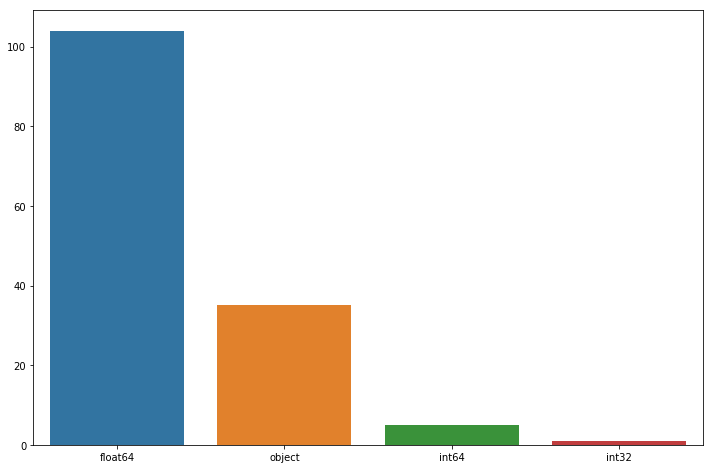

In [14]:
# Ploting the data types in the data set.
# We are concerned here with the object dtype, as sklearn takes only numeric data
data_type = data.dtypes.value_counts()
object_dtypes = data.columns[data.dtypes == object].values

plt.figure(figsize= (12,8))
sns.barplot (x = data_type.index, y = data_type.values);
print("List of object dtypes:\n\n",object_dtypes)
print("\n\nList of unrelevant object dtypes that will be intially dropped\n\n",drop_list)
print("\nThe number of numeric variables is:", len(data.columns[data.dtypes == 'float64']) + len(data.columns[data.dtypes == 'int64']))

In [15]:
# Get back numeric variables with zero count which are numerics that are uncountable
for i in data_count.index:
    if data_count.loc[i, 'count'] == 0:
        drop_list.append(i)
# Store in our dropping list variables with more than 20% null values-Drop the whole variable
for i in data.columns.values:
    if (data[i].isnull().sum() /len(data)) > 0.2:
        drop_list.append(i)

In [16]:
# Final drop list
drop_list

['sub_grade',
 'emp_title',
 'issue_d',
 'desc',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'sec_app_earliest_cr_line',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'debt_settlement_flag_date',
 'settlement_date',
 'id',
 'member_id',
 'url',
 'id',
 'member_id',
 'url',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util

####  All unnecessary variables have been dropped!

### Last phase of data dropping(Row wise):

In [17]:
# Get rid of unnecessary vairables. We use the .describe() attribute to get back the numerical columns
newdata = data.drop(drop_list, axis = 1)

In [20]:
newdata.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,10+ years,RENT,55000.0,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,10+ years,MORTGAGE,90000.0,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,6 years,MORTGAGE,59280.0,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,10+ years,MORTGAGE,92000.0,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,10+ years,MORTGAGE,57250.0,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
5,5550,5550,5550.0,36 months,15.02,192.45,C,10+ years,MORTGAGE,152500.0,...,60.0,0.0,0.0,831687.0,185378.0,65900.0,203159.0,N,Cash,N
6,2000,2000,2000.0,36 months,17.97,72.28,D,4 years,RENT,51000.0,...,NaN,0.0,0.0,854.0,854.0,0.0,0.0,N,Cash,N
7,6000,6000,6000.0,36 months,13.56,203.79,C,10+ years,RENT,65000.0,...,85.7,0.0,0.0,117242.0,91535.0,33100.0,61742.0,N,DirectPay,N
8,5000,5000,5000.0,36 months,17.97,180.69,D,10+ years,MORTGAGE,53580.0,...,60.0,0.0,0.0,57426.0,41882.0,21500.0,34626.0,N,Cash,N
9,6000,6000,6000.0,36 months,14.47,206.44,C,< 1 year,OWN,300000.0,...,26.3,0.0,0.0,477390.0,105911.0,98300.0,89600.0,N,Cash,N


In [21]:
df = pd.DataFrame({'Count': newdata.isnull().sum(), 'Percent(%)': 100*newdata.isnull().sum()/len(data)})
df[df['Count'] > 0]

,Count,Percent(%)
emp_length,146907,6.498472
dti,1711,0.075687
inq_last_6mths,1,0.000044
revol_util,1773,0.078429
collections_12_mths_ex_med,116,0.005131
tot_coll_amt,70247,3.107396
tot_cur_bal,70247,3.107396
total_rev_hi_lim,70247,3.107396
acc_open_past_24mths,50001,2.211808
avg_cur_bal,70317,3.110492


In [22]:
df['Percent(%)'].max(), df['Percent(%)'].median(), df['Percent(%)'].mean()
#Since mean > median of variables with NULL values, I decided to drop dataset rows where variable has NULL more than the mean

(13.067367235547117, 0.005131292523927969, 1.6062703668730105)

In [23]:
newdata.shape

(2260639, 78)

In [24]:
# dropping rows with variables missing vaules more than 5% of total data avialble
for i in list(newdata.columns.values):
    if (newdata[i].isnull().sum() /len(data)) > 0.05:
         newdata.dropna(subset=[i], how='all', inplace = True)

In [25]:
newdata.shape

(1778772, 78)

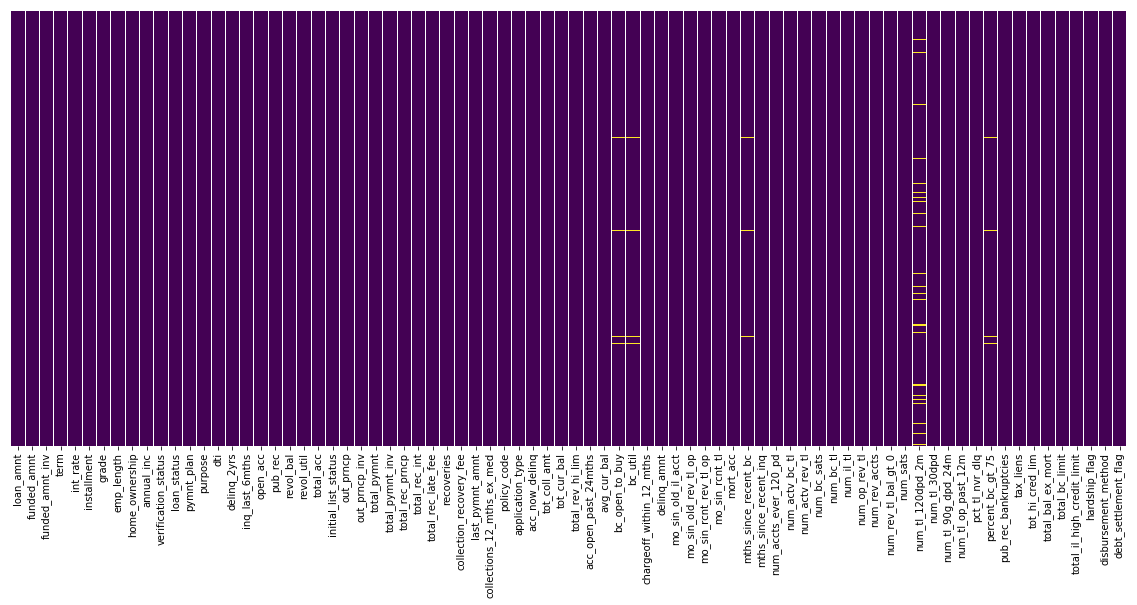

In [20]:
plt.figure(figsize= (20,8))
sns.heatmap(newdata.isnull(),yticklabels=False,cbar=False,cmap='viridis');

## Remaining Missing Values Imputation

In [26]:
df2 = pd.DataFrame({'Count': newdata.isnull().sum(), 'Percent(%)': 100*newdata.isnull().sum()/len(newdata)})
df2[df2['Count'] > 0]

,Count,Percent(%)
dti,85,0.004779
inq_last_6mths,1,0.000056
revol_util,1146,0.064426
avg_cur_bal,23,0.001293
bc_open_to_buy,18343,1.031217
bc_util,19250,1.082207
mths_since_recent_bc,17208,0.967409
num_rev_accts,1,0.000056
num_tl_120dpd_2m,74455,4.185753
pct_tl_nvr_dlq,125,0.007027


In [27]:
#dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
newdata.dti.fillna(newdata.dti.mean(),inplace=True)
#inq_last_6mths:  Credit inquiries in the last 6 months at time of application for the secondary applicant
newdata.inq_last_6mths.fillna(newdata.inq_last_6mths.mode()[0],inplace=True)
# revol_util:  Ratio of total current balance to high credit/credit limit for all revolving accounts
newdata.revol_util.fillna(newdata.revol_util.mean(),inplace=True) 
# avg_cur_bal: Average current balance of all accounts
newdata.avg_cur_bal.fillna(-100000000,inplace=True) 

#bc_open_to_buy: Total open to buy on revolving bankcards.
newdata.bc_open_to_buy.fillna(newdata.bc_open_to_buy.mode()[0],inplace=True) 

#bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
newdata.bc_util.fillna(newdata.bc_util.mean(),inplace=True) 

#mths_since_recent_bc:Months since most recent bankcard account opened.
newdata.mths_since_recent_bc.fillna(-100000000,inplace=True)

#num_rev_accts: Number of revolving accounts
newdata.num_rev_accts.fillna(-100000000,inplace=True)

#num_tl_120dpd_2m: Number of accounts currently 120 days past due (updated in past 2 months). Majority are zeros, replace with zero!
newdata.num_tl_120dpd_2m.fillna(0,inplace=True)

#pct_tl_nvr_dlq: Percent of trades never delinquent
newdata.pct_tl_nvr_dlq.fillna(newdata.pct_tl_nvr_dlq.mean(),inplace=True) 

#percent_bc_gt_75 :Percentage of all bankcard accounts > 75% of limit.
newdata.percent_bc_gt_75.fillna(newdata.percent_bc_gt_75.mode()[0],inplace=True)

In [28]:
# Check for any nulls
newdata.isnull().any().sum()

0

## Categorical Features Encoding

In [29]:
categorical_vars = list(newdata.columns[newdata.dtypes == object].values)
categorical_vars

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [30]:
obj_df = newdata.select_dtypes(include=['object']).copy()
obj_df.head()

,term,grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,10+ years,RENT,Not Verified,n,debt_consolidation,w,Individual,N,Cash,N
1,60 months,D,10+ years,MORTGAGE,Source Verified,n,debt_consolidation,w,Individual,N,Cash,N
2,36 months,D,6 years,MORTGAGE,Source Verified,n,debt_consolidation,w,Individual,N,Cash,N
3,36 months,D,10+ years,MORTGAGE,Source Verified,n,debt_consolidation,w,Individual,N,Cash,N
4,60 months,C,10+ years,MORTGAGE,Not Verified,n,debt_consolidation,w,Individual,N,Cash,N


In [31]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
for i in categorical_vars:
    obj_df[i] = lb_make.fit_transform(obj_df[i])
    

In [32]:
obj_df.head(10)

,term,grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,0,2,1,5,0,0,2,1,0,0,0,0
1,1,3,1,1,1,0,2,1,0,0,0,0
2,0,3,6,1,1,0,2,1,0,0,0,0
3,0,3,1,1,1,0,2,1,0,0,0,0
4,1,2,1,1,0,0,2,1,0,0,0,0
5,0,2,1,1,0,0,1,1,0,0,0,0
6,0,3,4,5,1,0,2,1,0,0,0,0
7,0,2,1,5,1,0,1,1,0,0,1,0
8,0,3,1,1,1,0,2,1,0,0,0,0
9,0,2,10,4,0,0,2,1,0,0,0,0


In [33]:
newdata.drop(categorical_vars,axis=1,inplace=True)

#### Model Data:

In [34]:
#Finally!!
model_data= pd.concat([newdata, obj_df],axis=1)

In [37]:
#Final check if all dtypes are numeric and NO NULL data found!
print("Number of nonNAN values in the refined dataset is: " ,model_data.isnull().any().sum())
print(model_data.dtypes.value_counts())

Number of nonNAN values in the refined dataset is:  0
float64    60
int32      13
int64       5
dtype: int64


## Train/Test Split

In [43]:
# Splitting the data manuelly is more appropriate to train and test model on than random shuffeling 
# We can awitch the target with account delinquent, but we are predicting if the individual will default
target = 'loan_status'
X = model_data.drop(target, axis = 1)
Y = model_data[target]

#### Note:
    Our target variable classes are unbalanced from the count in the cell below. Since we are implementing a tree based algorithm, our model will perform well on this imbalanced dataset due to the hierarchical structure of the algorithm which allows the model to learn signals from both classes: "0" and "1".  

In [44]:
Y.value_counts()

1    1551038
0     227734
Name: loan_status, dtype: int64

In [45]:
split_percentage = 0.2
split = int(split_percentage*len(model_data))

# Train data set
X_train = X[split:]
y_train = Y[split:] 

# Test data set
X_test = X[:split]
y_test = Y[:split]

In [46]:
params = {'n_estimators': 3,'max_leaf_nodes':6,'learning_rate': 0.1, 'random_state':1}
model = ensemble.GradientBoostingClassifier(**params)
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=6,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
# calculate AUC
roc_auc_score(y_test, model.predict(X_test))

0.5

In [48]:
# A better model
params = {'n_estimators': 30,'max_leaf_nodes':6,'learning_rate': 0.1, 'random_state':1}
model = ensemble.GradientBoostingClassifier(**params)
model.fit(X_train, y_train)

roc_auc_score(y_test, model.predict(X_test))

0.7166258598577591

### Parameter Tuning Using Loops

In [49]:
# now we run a grid search on GBM parameters
# save the results to choose the best parameters
results = pd.DataFrame(columns=["# Trees", "Max Features", "Learning Rate",
                                "Max Leaf Nodes", "Min Split","AUC-Train","AUC-Test", "Loss"])
n = 0    
for n_estimators in [1, 2]:
        for max_features in ['sqrt','auto']:
                for learning_rate in [0.001, 0.01, 0.1, 0.5]:
                    for max_leaf_nodes in [6, 8, 12, 16, 20]:
                            for min_samples_split in [0.00001, 0.1, 0.2, 0.3]:
                                n += 1
                                print(n)
                                params = {'n_estimators': n_estimators,  
                                  'max_features':max_features,'max_leaf_nodes':max_leaf_nodes, 
                                  'learning_rate': learning_rate, 
                                  'min_samples_split': min_samples_split,
                                  'subsample':0.8, 'random_state':1}
                                model = ensemble.GradientBoostingClassifier(**params)
                                model.fit(X, Y)
                                results.loc[len(results)]=[n_estimators, max_features, learning_rate,
                                               max_leaf_nodes, min_samples_split,
                                               roc_auc_score(y_train, model.predict(X_train)),
                                               roc_auc_score(y_test, model.predict(X_test)),
                                               model.loss_(y_test,model.predict(X_test))]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [50]:
results.sort_values(by=['AUC-Train','AUC-Test','Loss'])

,# Trees,Max Features,Learning Rate,Max Leaf Nodes,Min Split,AUC-Train,AUC-Test,Loss
0,1,sqrt,0.001,6,0.00001,0.500000,0.500000,0.674742
1,1,sqrt,0.001,6,0.10000,0.500000,0.500000,0.674742
2,1,sqrt,0.001,6,0.20000,0.500000,0.500000,0.674742
3,1,sqrt,0.001,6,0.30000,0.500000,0.500000,0.674742
4,1,sqrt,0.001,8,0.00001,0.500000,0.500000,0.674742
5,1,sqrt,0.001,8,0.10000,0.500000,0.500000,0.674742
6,1,sqrt,0.001,8,0.20000,0.500000,0.500000,0.674742
7,1,sqrt,0.001,8,0.30000,0.500000,0.500000,0.674742
8,1,sqrt,0.001,12,0.00001,0.500000,0.500000,0.674742
9,1,sqrt,0.001,12,0.10000,0.500000,0.500000,0.674742


In [51]:
#choosing best parameters from gridsearch
params = {'n_estimators': 2,'max_features':'auto','max_leaf_nodes':20,
          'learning_rate': 0.5,'min_samples_split': 0.3,'subsample':0.8, 'random_state':1}
best_model = ensemble.GradientBoostingClassifier(**params)
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=20,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.3,
                           min_weight_fraction_leaf=0.0, n_estimators=2,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Optional GridSearch(): My Computer is super slow

In [ ]:
#### GRIDSEARCH #### 
#Hypertuning parameters
param_grid = {'n_estimators': [1, 2], 'max_features': ['sqrt','auto'], 'learning_rate': [0.001, 0.01, 0.1], 'max_leaf_nodes': [6, 8, 12, 16, 20], 'min_samples_split': [0.00001, 0.1, 0.2]}
grid = GridSearchCV(ensemble.GradientBoostingClassifier(),param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)
print(grid.best_params_)

### Feature Importance

In [52]:
feature_importance = pd.DataFrame()
feature_importance['Variable'] = X_train.columns
feature_importance['Importance'] = best_model.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='Importance', ascending=False).head(10)


,Variable,Importance
21,recoveries,0.907314
18,total_rec_prncp,0.055548
76,debt_settlement_flag,0.022381
23,last_pymnt_amnt,0.014758
56,num_tl_op_past_12m,0.000000
55,num_tl_90g_dpd_24m,0.000000
54,num_tl_30dpd,0.000000
53,num_tl_120dpd_2m,0.000000
52,num_sats,0.000000
51,num_rev_tl_bal_gt_0,0.000000


In [53]:
proba_classes = pd.DataFrame()
proba_classes['Y']= y_test
proba_classes['Class:0'] = best_model.predict_proba(X_test)[:, 0]
proba_classes['Class:1'] = best_model.predict_proba(X_test)[:, 1]
proba_classes.head()

,Y,Class:0,Class:1
0,1,0.435333,0.564667
1,1,0.435333,0.564667
2,1,0.435333,0.564667
3,1,0.435333,0.564667
4,1,0.435333,0.564667


### Histogram of Class Probabilities
If the model is very good, it should assign probabilities to the two different classes in a way it completely separates and distinguishes between the two classes. The "0" class would be visualized towards the left, and the 1 class would be visualized towrad the right.

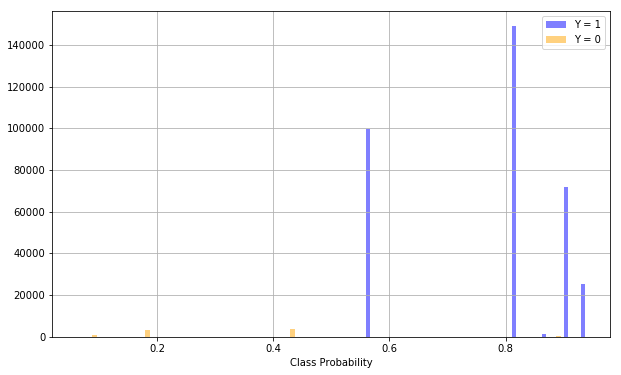

In [54]:
plt.figure(figsize=(10,6))
proba_classes[proba_classes.Y==1]['Class:1'].hist(alpha=0.5,color='blue',
                                              bins=100,label='Y = 1')
proba_classes[proba_classes.Y==0]['Class:0'].hist(alpha=0.5,color='orange',
                                              bins=100,label='Y = 0')
plt.legend()
plt.xlabel('Class Probability');

In [55]:
def heldout_score(model, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(model.staged_decision_function(X_test)):
        score[i] = model.loss_(y_test, y_pred)
    return score

In [56]:
test_score = heldout_score(best_model, X_test, y_test)

In [57]:
test_score

array([0.45956314, 0.60465402])